## Fused LASSO with sparsity

This notebook provides some ways to solve the sparse fused LASSO problem

$$
\frac{1}{2}\|y - \beta\|^2_2 + \lambda_{1}\|D\beta\|_{1} + \lambda_2 \|\beta\|_1
$$

In [15]:
# third party imports
import numpy as np
%pylab inline
from scipy import sparse

# the regreg import
import regreg.api as rr

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


We will use the CGH data from the R package cghFLasso. You will have to have installed the package 'cghFLasso' in R, as well as installed rpy2.

/home/jb/.virtualenvs/py2/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


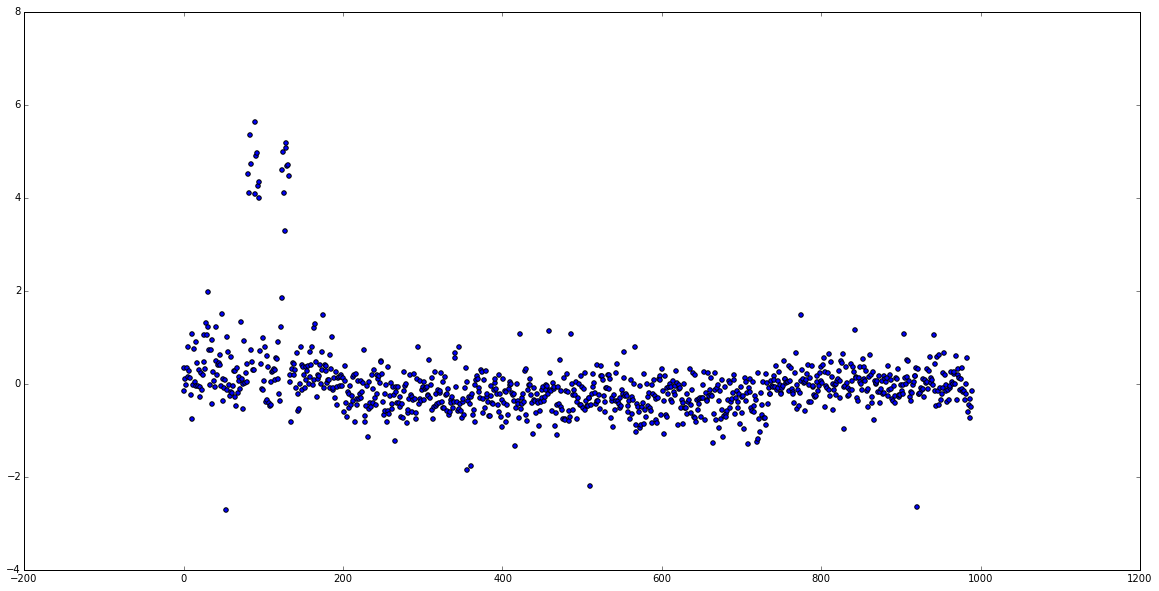

In [16]:
import rpy2.robjects as ri
ri.r('''
# You 
library(cghFLasso)
data(CGH)
Y = CGH$GBM.y
''')
Y = np.array(ri.r('Y'))
n = Y.shape[0]
pylab.figure(figsize=(20,10))
pylab.scatter(np.arange(n), Y)

Let's specify two penalties, one for "smoothness", i.e. piecewise constant behaviour, the other for sparsity. For "smoothness" we need to create the
matrix of first order differences. There is a class of affine transforms in {\bf regreg.affine} that can compute this and return it as a 
sparse matrix.

In [17]:
loss = rr.signal_approximator(Y)
sparsity = rr.l1norm(n, lagrange=0.3)
print rr.__file__
import regreg.affine.fused_lasso as FL
from regreg.affine.fused_lasso import difference_transform
D = difference_transform(np.arange(n), order=1, sorted=True)

# Let's just verify it is the matrix of first order differences
print D[:4,:5].todense()

fused = rr.l1norm.linear(D, lagrange=2.8)

/home/jb/code/regreg/regreg/api.pyc
[[-1.  1.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.]
 [ 0.  0. -1.  1.  0.]
 [ 0.  0.  0. -1.  1.]]


Finally, we will create the problem. We will solve this as a dual problem where the primal objective is {\bf loss}=${\cal L}$ so the dual objective is ${\cal L}^*(-u_s-D^Tu_f)$ with $u_s$ dual variables for the sparsity
term and $u_f$ dual variables for the fused term.


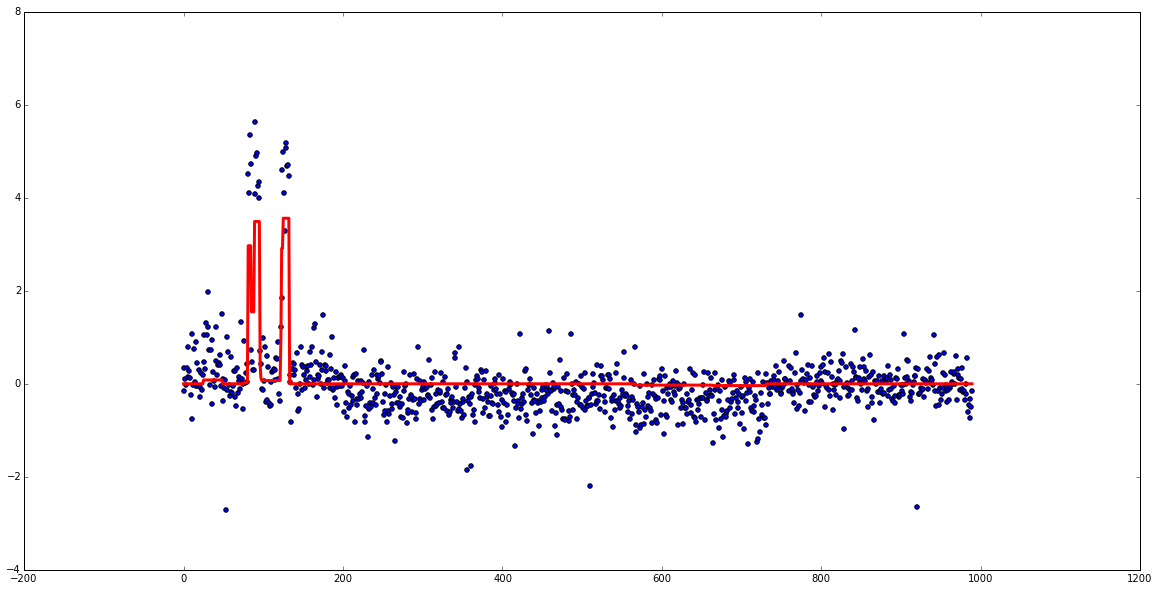

In [18]:
problem = rr.dual_problem.fromprimal(loss, sparsity, fused)
smooth_and_sparse_coefs = problem.solve(tol=1.e-14)
pylab.figure(figsize=(20,10))
pylab.plot(np.arange(n), smooth_and_sparse_coefs, linewidth=3, c='r')
pylab.scatter(np.arange(n), Y)

## Fused LASSO without sparsity

Of course, we can also solve the problem without the sparsity penalty.


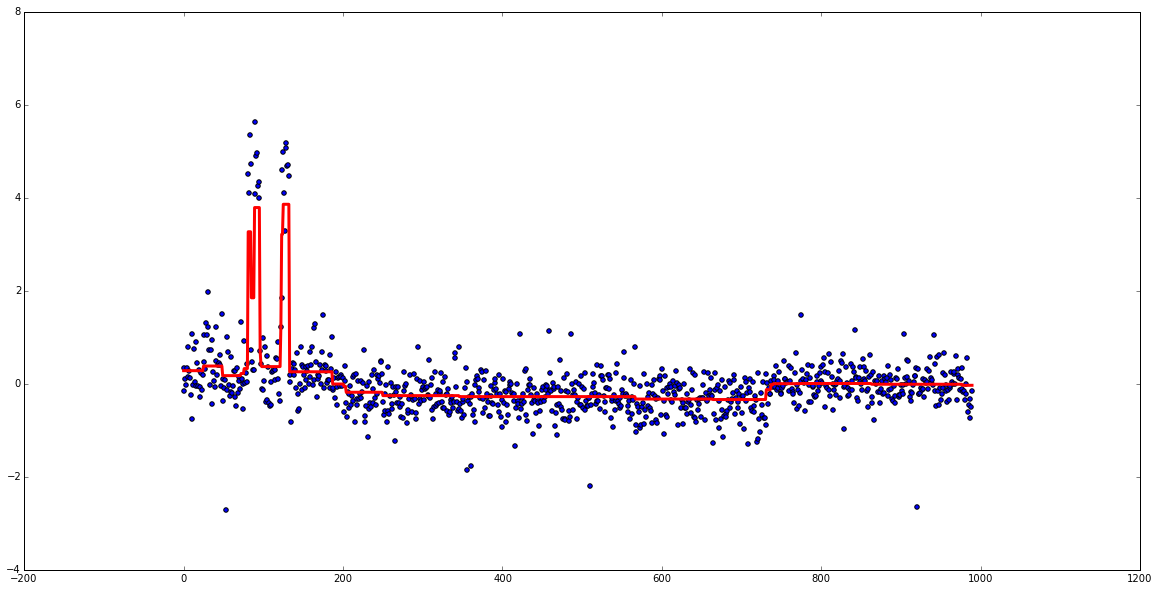

In [19]:
problem = rr.dual_problem.fromprimal(loss, fused)
smooth_coefs = problem.solve(tol=1.e-14)
pylab.figure(figsize=(20,10))
pylab.plot(np.arange(n), smooth_coefs, linewidth=3, c='r')
pylab.scatter(np.arange(n), Y)

## Fused LASSO via smoothing the TV term

Rather than solve the dual problem, we might also consider smoothing the {\bf fused} penalty and keeping a sparsity penalty. The smoothing is accomplished by using
a small quadratic term. This results in a separable problem with just the $\ell_1$ penalty. There are now several smooth terms, we lump
them together in the container.

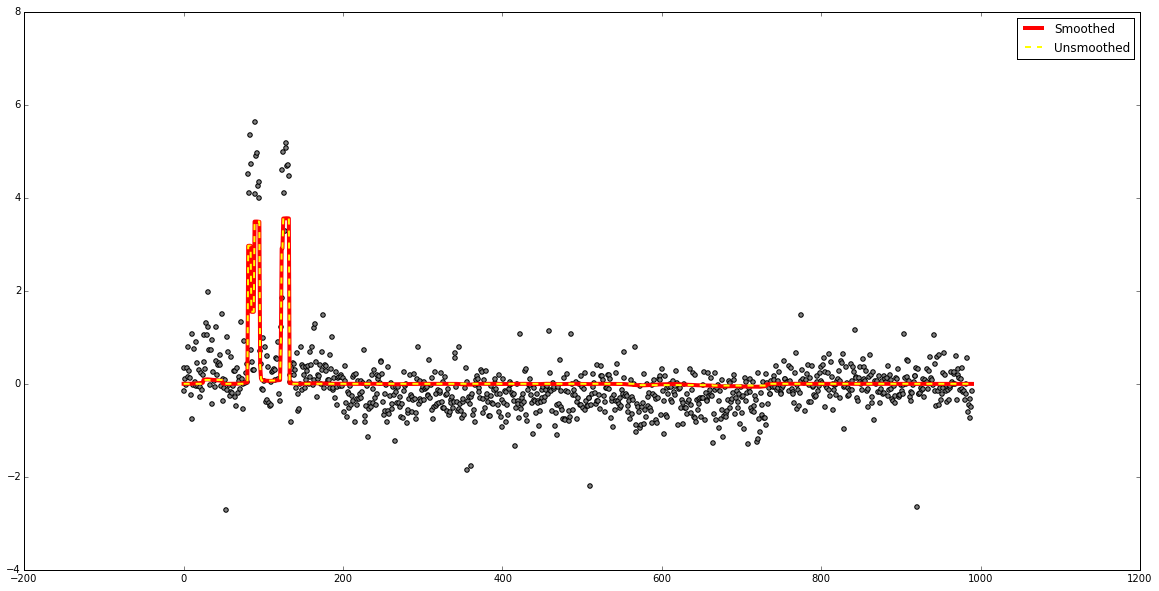

In [20]:
sq = rr.identity_quadratic(0.001, 0, 0, 0)
fused_smooth = fused.smoothed(sq)
problem = rr.container(loss, fused_smooth, sparsity)
smoothed_smooth_and_sparse_coefs = problem.solve()
pylab.figure(figsize=(20,10))
pylab.plot(np.arange(n), smoothed_smooth_and_sparse_coefs, linewidth=4, c='r', label='Smoothed')
pylab.plot(np.arange(n), smooth_and_sparse_coefs, linewidth=2, c='yellow', linestyle='--', label='Unsmoothed')
pylab.scatter(np.arange(n), Y, facecolor='gray')
pylab.legend()

We can also solve the problem without the sparsity


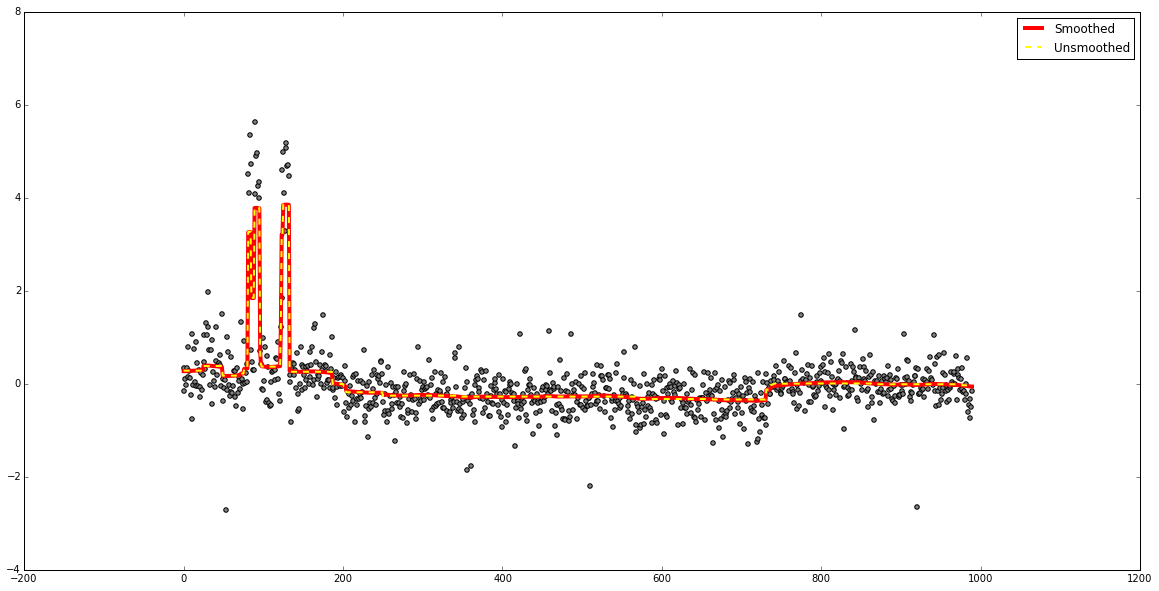

In [21]:

fused_smooth = fused.smoothed(sq)
problem = rr.container(loss, fused_smooth)
smoothed_smooth_coefs = problem.solve()
pylab.figure(figsize=(20,10))
pylab.plot(np.arange(n), smoothed_smooth_coefs, linewidth=4, c='r', label='Smoothed')
pylab.plot(np.arange(n), smooth_coefs, linewidth=2, c='yellow', linestyle='--', label='Unsmoothed')
pylab.scatter(np.arange(n), Y, facecolor='gray')
pylab.legend()

## Adding offsets to penalties

In some cases, we may want to shrink to some value other than zero. This can be achieved by adding an offset to the seminorm. For instance, we might
want to shrink towards 2. We might do this by solving
$$ \frac{1}{2}||y - \beta||^2_2 + \lambda_{1}||D\beta||_{1} + \lambda_2 \|\beta-2\|_1 $$
This is an offset of -2.

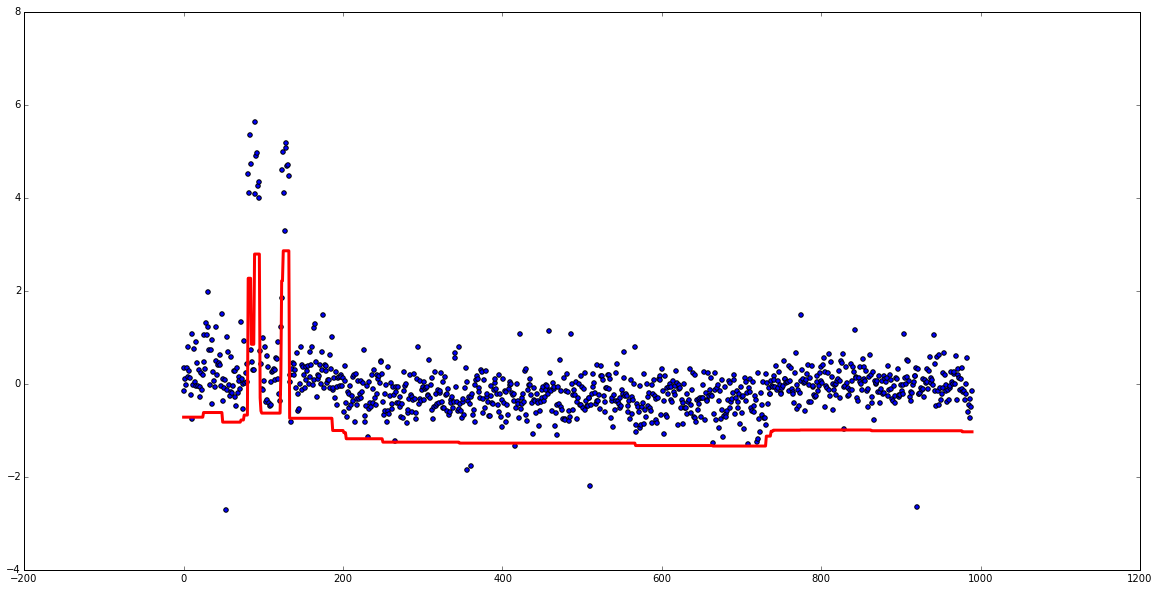

In [22]:
sparsity_2 = rr.l1norm(n, offset=-2*np.ones(n), lagrange=1)
problem = rr.dual_problem.fromprimal(loss, sparsity_2, fused)
smooth_and_sparse2_coefs = problem.solve(tol=1.e-14)
pylab.figure(figsize=(20,10))
pylab.plot(np.arange(n), smooth_and_sparse2_coefs, linewidth=3, c='r')
pylab.scatter(np.arange(n), Y)

By increasing the penalty on the sparsity_2 term, we shrink all the way to the constant solution $2  \cdot \pmb{1}$.

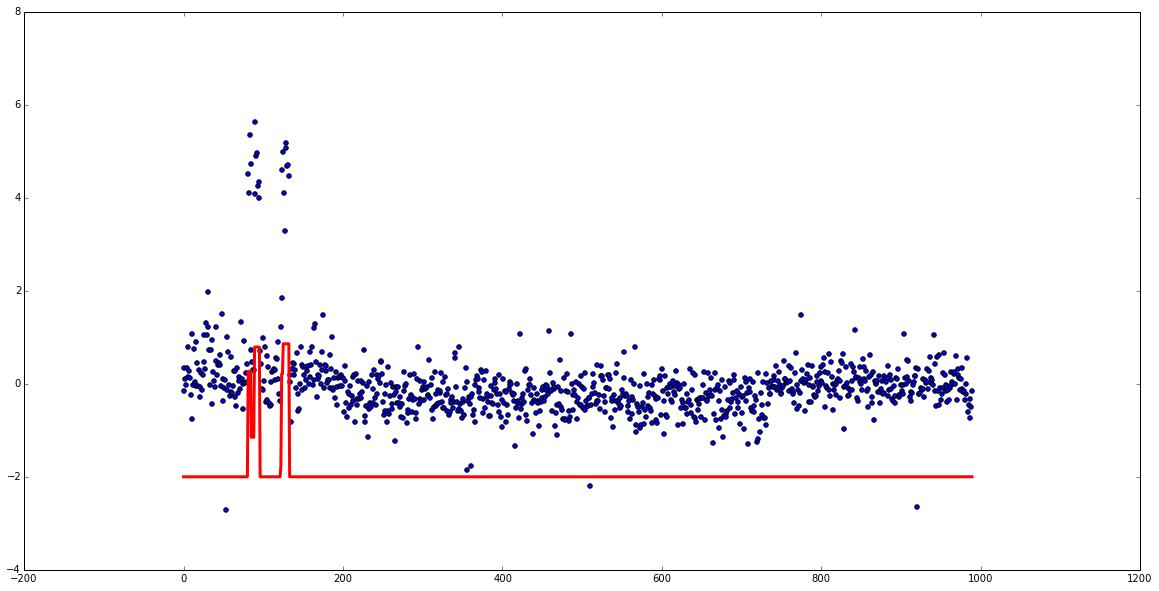

In [23]:
sparsity_2.lagrange = 3
problem = rr.dual_problem.fromprimal(loss, sparsity_2, fused)
smooth_and_sparse2_coefs = problem.solve(tol=1.e-14)
pylab.figure(figsize=(20,10))
pylab.plot(np.arange(n), smooth_and_sparse2_coefs, linewidth=3, c='r')
pylab.scatter(np.arange(n), Y)

Of course, we can set the offset to be some other vector as well


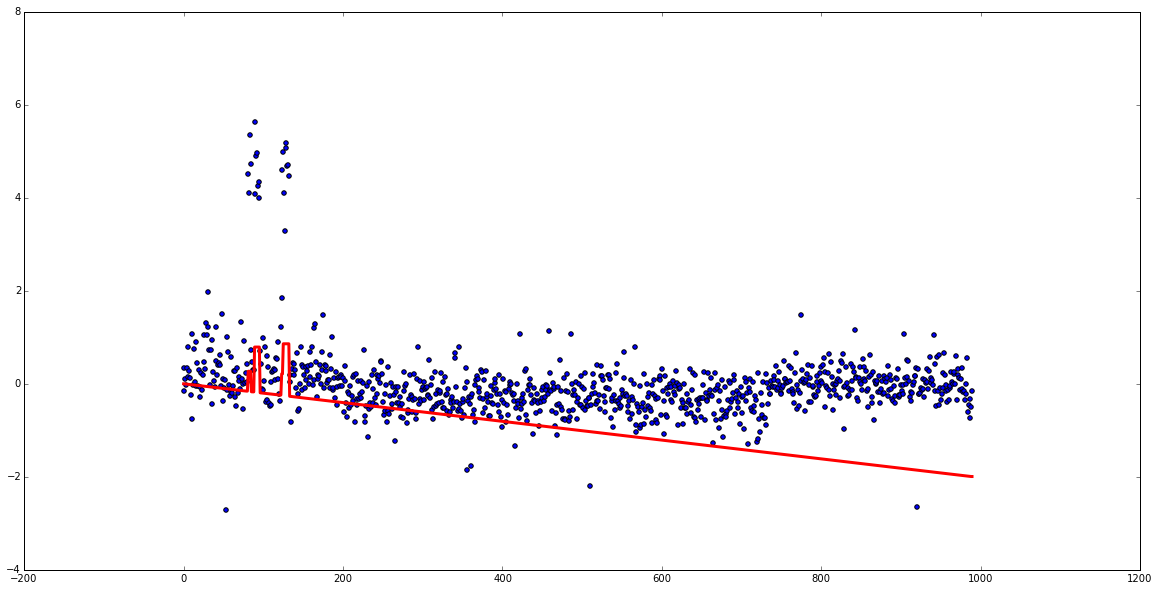

In [24]:
sparsity_2.offset = -np.arange(n) * 2. / n
problem = rr.dual_problem.fromprimal(loss, sparsity_2, fused)
smooth_and_sparse2_coefs = problem.solve(tol=1.e-14)
pylab.figure(figsize=(20,10))
pylab.plot(np.arange(n), smooth_and_sparse2_coefs, linewidth=3, c='r')
pylab.scatter(np.arange(n), Y)

## Constraint form

We might also try a constrained form of the problem, rather than the Lagrange form. For instance, we might
constrain the $\ell_1$ norm to be less than or equal to 50.

sparsity 50.0


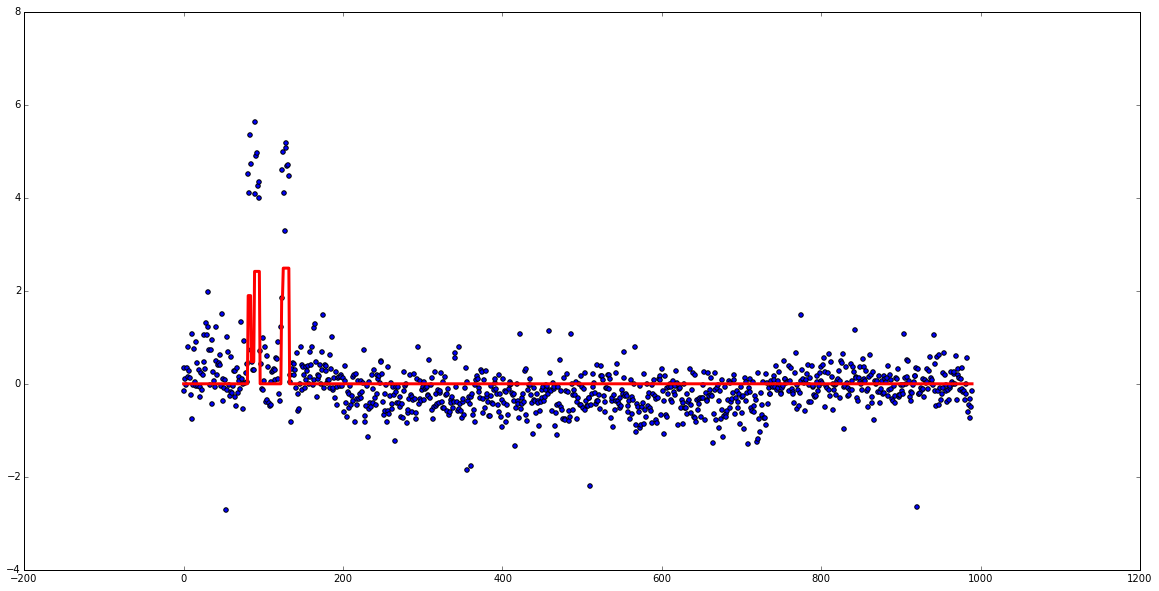

In [25]:
sparsity_bound = rr.l1norm(n, bound=50)
problem = rr.dual_problem.fromprimal(loss, sparsity_bound, fused)
smooth_and_sparse_coefs = problem.solve(tol=1.e-14)
pylab.figure(figsize=(20,10))
pylab.plot(np.arange(n), smooth_and_sparse_coefs, linewidth=3, c='r')
pylab.scatter(np.arange(n), Y)
print 'sparsity %0.1f' % np.fabs(smooth_and_sparse_coefs).sum()

Alternatively, we might constrain the $\ell_1$ norm of $D\hat{\beta}$ to be less than 10, and keep the Lagrange form for the sparsity.

fused 10.0


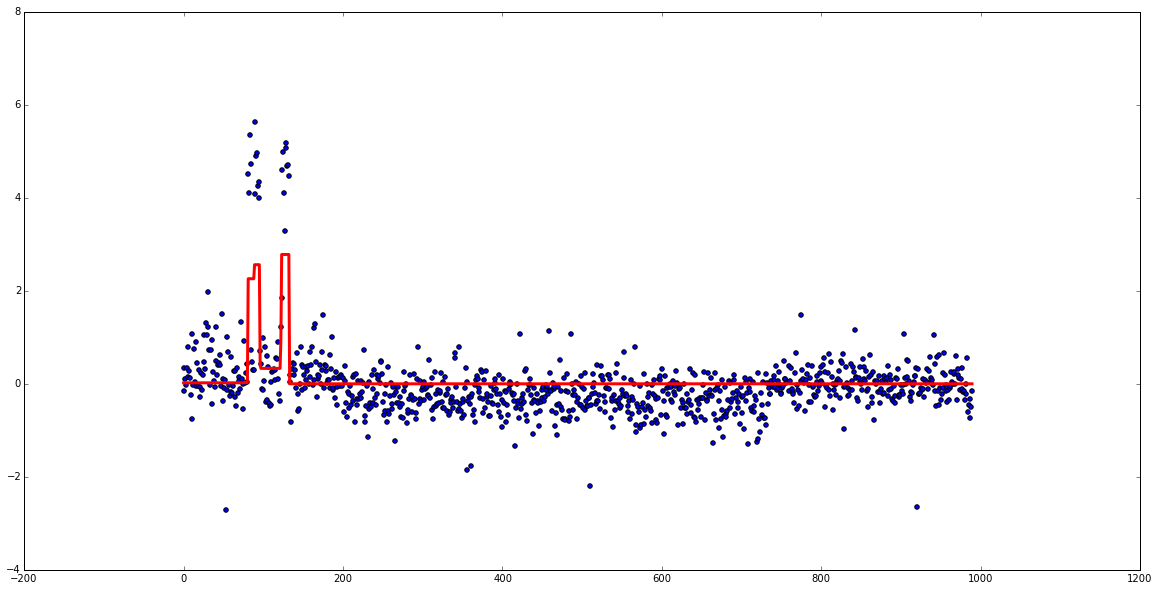

In [26]:

fused_bound = rr.l1norm.linear(D, bound=10)
problem = rr.dual_problem.fromprimal(loss, sparsity, fused_bound)
smooth_and_sparse_coefs = problem.solve(tol=1.e-14)
pylab.figure(figsize=(20,10))
pylab.plot(np.arange(n), smooth_and_sparse_coefs, linewidth=3, c='r')
pylab.scatter(np.arange(n), Y)
print 'fused %0.1f' % np.fabs(D*smooth_and_sparse_coefs).sum()

We can also keep them both in bound form. At a solution, of course, they may not be both tight.

sparsity: 50.0
fused: 10.0


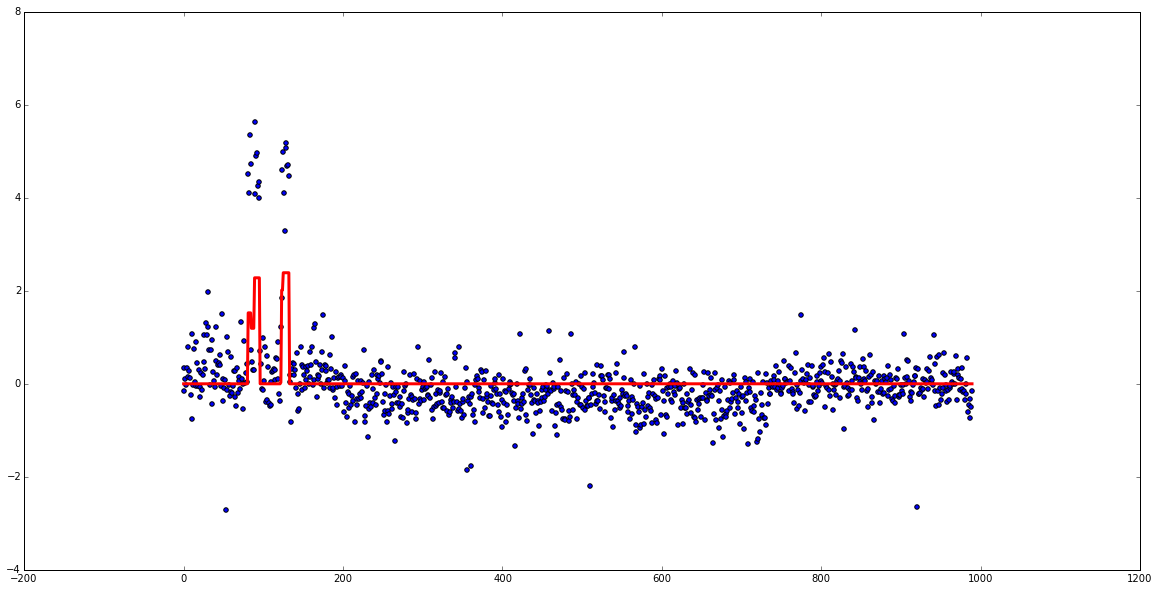

In [27]:
problem = rr.dual_problem.fromprimal(loss, sparsity_bound, fused_bound)
smooth_and_sparse_coefs = problem.solve(tol=1.e-14)
pylab.figure(figsize=(20,10))
pylab.plot(np.arange(n), smooth_and_sparse_coefs, linewidth=3, c='r')
pylab.scatter(np.arange(n), Y)
print 'sparsity: %0.1f' % np.fabs(smooth_and_sparse_coefs).sum()
print 'fused: %0.1f' % np.fabs(D*smooth_and_sparse_coefs).sum()

sparsity: 274.3
fused: 10.0


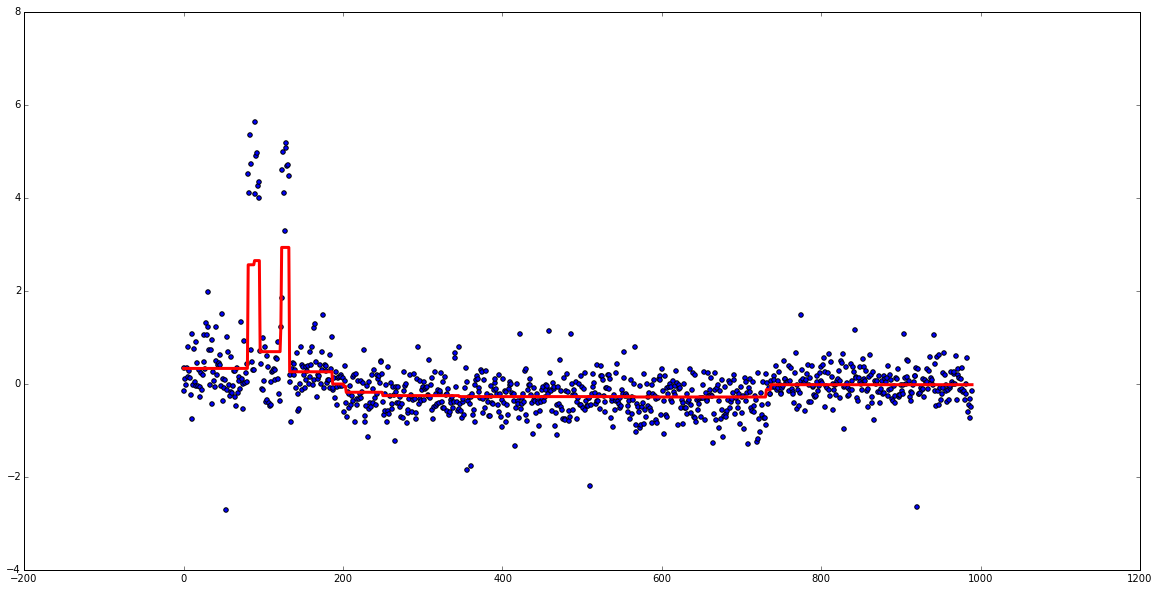

In [28]:
sparsity_bound.bound = 500
problem = rr.dual_problem.fromprimal(loss, sparsity_bound, fused_bound)
smooth_and_sparse_coefs = problem.solve(tol=1.e-14)
pylab.figure(figsize=(20,10))
pylab.plot(np.arange(n), smooth_and_sparse_coefs, linewidth=3, c='r')
pylab.scatter(np.arange(n), Y)
print 'sparsity: %0.1f' % np.fabs(smooth_and_sparse_coefs).sum()
print 'fused: %0.1f' % np.fabs(D*smooth_and_sparse_coefs).sum()